# Exercise solutions

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [113]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [114]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [115]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's fetch the MNIST dataset:

In [116]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [117]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

In [118]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.128663	Best loss: 0.128663	Accuracy: 96.64%
1	Validation loss: 0.448317	Best loss: 0.128663	Accuracy: 78.19%
2	Validation loss: 0.190859	Best loss: 0.128663	Accuracy: 95.54%
3	Validation loss: 0.146951	Best loss: 0.128663	Accuracy: 96.79%
4	Validation loss: 0.086076	Best loss: 0.086076	Accuracy: 97.69%
5	Validation loss: 0.115353	Best loss: 0.086076	Accuracy: 97.77%
6	Validation loss: 0.239142	Best loss: 0.086076	Accuracy: 95.15%
7	Validation loss: 0.088810	Best loss: 0.086076	Accuracy: 98.12%
8	Validation loss: 0.108763	Best loss: 0.086076	Accuracy: 97.81%
9	Validation loss: 0.300808	Best loss: 0.086076	Accuracy: 96.17%
10	Validation loss: 0.179260	Best loss: 0.086076	Accuracy: 97.46%
11	Validation loss: 0.125690	Best loss: 0.086076	Accuracy: 98.48%
12	Validation loss: 0.738371	Best loss: 0.086076	Accuracy: 77.72%
13	Validation loss: 1.894743	Best loss: 0.086076	Accuracy: 78.54%
14	Validation loss: 0.415678	Best loss: 0.086076	Accuracy: 78.50%
15	Validation loss: 

We get 98.05% accuracy on the test set. That's not too bad, but let's see if we can do better by tuning the hyperparameters.

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [119]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [120]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.128663	Best loss: 0.128663	Accuracy: 96.64%
1	Validation loss: 0.448317	Best loss: 0.128663	Accuracy: 78.19%
2	Validation loss: 0.190859	Best loss: 0.128663	Accuracy: 95.54%
3	Validation loss: 0.146951	Best loss: 0.128663	Accuracy: 96.79%
4	Validation loss: 0.086076	Best loss: 0.086076	Accuracy: 97.69%
5	Validation loss: 0.115353	Best loss: 0.086076	Accuracy: 97.77%
6	Validation loss: 0.239142	Best loss: 0.086076	Accuracy: 95.15%
7	Validation loss: 0.088810	Best loss: 0.086076	Accuracy: 98.12%
8	Validation loss: 0.108763	Best loss: 0.086076	Accuracy: 97.81%
9	Validation loss: 0.300808	Best loss: 0.086076	Accuracy: 96.17%
10	Validation loss: 0.179260	Best loss: 0.086076	Accuracy: 97.46%
11	Validation loss: 0.125690	Best loss: 0.086076	Accuracy: 98.48%
12	Validation loss: 0.738371	Best loss: 0.086076	Accuracy: 77.72%
13	Validation loss: 1.894743	Best loss: 0.086076	Accuracy: 78.54%
14	Validation loss: 0.415678	Best loss: 0.086076	Accuracy: 78.50%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The model is trained, let's see if it gets the same accuracy as earlier:

In [121]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98054096127651291

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [122]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1)

# fit_params as a constructor argument was deprecated in Scikit-Learn version 0.19 and will
# be removed in version 0.21. Pass fit parameters to the fit() method instead:
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 random_state=42, verbose=2)
# fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
# rnd_search.fit(X_train1, y_train1, **fit_params)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, activation=<function elu at 0x7fd9e8a620d0>, batch_size=100 
0	Validation loss: 0.132355	Best loss: 0.132355	Accuracy: 96.44%
1	Validation loss: 0.126329	Best loss: 0.126329	Accuracy: 96.21%
2	Validation loss: 0.138284	Best loss: 0.126329	Accuracy: 96.76%
3	Validation loss: 0.142094	Best loss: 0.126329	Accuracy: 96.25%
4	Validation loss: 0.128141	Best loss: 0.126329	Accuracy: 96.76%
5	Validation loss: 0.119928	Best loss: 0.119928	Accuracy: 97.26%
6	Validation loss: 0.137134	Best loss: 0.119928	Accuracy: 96.72%
7	Validation loss: 0.156194	Best loss: 0.119928	Accuracy: 96.79%
8	Validation loss: 0.283938	Best loss: 0.119928	Accuracy: 94.53%
9	Validation loss: 1.104801	Best loss: 0.119928	Accuracy: 52.38%
10	Validation loss: 0.966833	Best loss: 0.119928	Accuracy: 53.09%
11	Validation loss: 0.854368	Best loss: 0.119928	Accuracy: 57.47%
12	Validation loss: 1.857330	Best loss: 0.119928	Accurac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


0	Validation loss: 0.153707	Best loss: 0.153707	Accuracy: 95.74%
1	Validation loss: 0.120703	Best loss: 0.120703	Accuracy: 96.56%
2	Validation loss: 0.164706	Best loss: 0.120703	Accuracy: 96.05%
3	Validation loss: 0.177875	Best loss: 0.120703	Accuracy: 95.19%
4	Validation loss: 0.171004	Best loss: 0.120703	Accuracy: 95.19%
5	Validation loss: 0.114746	Best loss: 0.114746	Accuracy: 96.83%
6	Validation loss: 0.109637	Best loss: 0.109637	Accuracy: 97.26%
7	Validation loss: 0.261533	Best loss: 0.109637	Accuracy: 94.96%
8	Validation loss: 0.316743	Best loss: 0.109637	Accuracy: 94.02%
9	Validation loss: 0.486484	Best loss: 0.109637	Accuracy: 77.56%
10	Validation loss: 4.635532	Best loss: 0.109637	Accuracy: 53.95%
11	Validation loss: 1.172422	Best loss: 0.109637	Accuracy: 48.36%
12	Validation loss: 1.029865	Best loss: 0.109637	Accuracy: 55.98%
13	Validation loss: 1.298800	Best loss: 0.109637	Accuracy: 36.08%
14	Validation loss: 1.141950	Best loss: 0.109637	Accuracy: 38.08%
15	Validation loss: 

32	Validation loss: 0.083471	Best loss: 0.065671	Accuracy: 98.40%
33	Validation loss: 0.086415	Best loss: 0.065671	Accuracy: 98.59%
34	Validation loss: 0.085613	Best loss: 0.065671	Accuracy: 98.36%
35	Validation loss: 0.099534	Best loss: 0.065671	Accuracy: 98.28%
36	Validation loss: 0.102709	Best loss: 0.065671	Accuracy: 98.32%
37	Validation loss: 0.093125	Best loss: 0.065671	Accuracy: 98.20%
38	Validation loss: 0.109501	Best loss: 0.065671	Accuracy: 97.85%
39	Validation loss: 0.109443	Best loss: 0.065671	Accuracy: 98.44%
40	Validation loss: 0.087260	Best loss: 0.065671	Accuracy: 98.36%
41	Validation loss: 0.106365	Best loss: 0.065671	Accuracy: 98.36%
42	Validation loss: 0.102789	Best loss: 0.065671	Accuracy: 98.05%
43	Validation loss: 0.094281	Best loss: 0.065671	Accuracy: 98.48%
44	Validation loss: 0.094514	Best loss: 0.065671	Accuracy: 98.40%
[...and much later...]
20	Validation loss: 0.046808	Best loss: 0.033867	Accuracy: 98.83%
21	Validation loss: 0.052966	Best loss: 0.033867	Accu

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fd9e8a660d0>, <function elu at 0x7fd9e8a620d0>, <function leaky_rel

In [123]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [124]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99318933644677954

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [125]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [126]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.090732	Best loss: 0.090732	Accuracy: 97.22%
1	Validation loss: 0.052198	Best loss: 0.052198	Accuracy: 98.40%
2	Validation loss: 0.040040	Best loss: 0.040040	Accuracy: 98.94%
3	Validation loss: 0.057495	Best loss: 0.040040	Accuracy: 98.55%
4	Validation loss: 0.045600	Best loss: 0.040040	Accuracy: 98.75%
5	Validation loss: 0.062344	Best loss: 0.040040	Accuracy: 98.48%
6	Validation loss: 0.048719	Best loss: 0.040040	Accuracy: 98.67%
7	Validation loss: 0.050346	Best loss: 0.040040	Accuracy: 98.79%
8	Validation loss: 0.051224	Best loss: 0.040040	Accuracy: 98.79%
9	Validation loss: 0.036505	Best loss: 0.036505	Accuracy: 98.98%
10	Validation loss: 0.052532	Best loss: 0.036505	Accuracy: 98.71%
11	Validation loss: 0.057086	Best loss: 0.036505	Accuracy: 99.10%
12	Validation loss: 0.036754	Best loss: 0.036505	Accuracy: 99.06%
13	Validation loss: 0.046782	Best loss: 0.036505	Accuracy: 98.87%
14	Validation loss: 0.048929	Best loss: 0.036505	Accuracy: 98.91%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9d19e37b8>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best loss is reached at epoch 19, but it was already within 10% of that result at epoch 9.

Let's check that we do indeed get 99.32% accuracy on the test set:

In [127]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99318933644677954

Good, now let's use the exact same model, but this time with batch normalization:

In [128]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.046053	Best loss: 0.046053	Accuracy: 98.67%
1	Validation loss: 0.032228	Best loss: 0.032228	Accuracy: 98.83%
2	Validation loss: 0.032974	Best loss: 0.032228	Accuracy: 98.83%
3	Validation loss: 0.035961	Best loss: 0.032228	Accuracy: 98.94%
4	Validation loss: 0.040250	Best loss: 0.032228	Accuracy: 98.94%
5	Validation loss: 0.033051	Best loss: 0.032228	Accuracy: 99.06%
6	Validation loss: 0.056053	Best loss: 0.032228	Accuracy: 98.32%
7	Validation loss: 0.031729	Best loss: 0.031729	Accuracy: 99.18%
8	Validation loss: 0.027662	Best loss: 0.027662	Accuracy: 99.26%
9	Validation loss: 0.034074	Best loss: 0.027662	Accuracy: 98.94%
10	Validation loss: 0.032173	Best loss: 0.027662	Accuracy: 99.06%
11	Validation loss: 0.030538	Best loss: 0.027662	Accuracy: 99.10%
12	Validation loss: 0.030337	Best loss: 0.027662	Accuracy: 99.10%
13	Validation loss: 0.022219	Best loss: 0.022219	Accuracy: 99.45%
14	Validation loss: 0.036824	Best loss: 0.022219	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9d19e3c80>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 48, that's actually a slower convergence than earlier. Let's check the accuracy:

In [129]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784003

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [130]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] activation=<function relu at 0x7fd9e8a660d0>, n_neurons=70, learning_rate=0.01, batch_norm_momentum=0.99, batch_size=50 
0	Validation loss: 0.113224	Best loss: 0.113224	Accuracy: 97.30%
1	Validation loss: 0.064190	Best loss: 0.064190	Accuracy: 98.24%
2	Validation loss: 0.080173	Best loss: 0.064190	Accuracy: 98.28%
3	Validation loss: 0.059603	Best loss: 0.059603	Accuracy: 98.28%
4	Validation loss: 0.043533	Best loss: 0.043533	Accuracy: 98.48%
5	Validation loss: 0.040107	Best loss: 0.040107	Accuracy: 98.87%
6	Validation loss: 0.051212	Best loss: 0.040107	Accuracy: 98.24%
7	Validation loss: 0.046029	Best loss: 0.040107	Accuracy: 98.71%
8	Validation loss: 0.053079	Best loss: 0.040107	Accuracy: 98.59%
9	Validation loss: 0.066891	Best loss: 0.040107	Accuracy: 98.28%
10	Validation loss: 0.037712	Best loss: 0.037712	Accuracy: 98.83%
11	Validation loss: 0.055569	Best loss: 0.037712	Accuracy: 98.55%
12	Validation loss: 0.040949	B

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


0	Validation loss: 0.144984	Best loss: 0.144984	Accuracy: 96.40%
1	Validation loss: 0.067873	Best loss: 0.067873	Accuracy: 98.44%
2	Validation loss: 0.091854	Best loss: 0.067873	Accuracy: 97.30%
3	Validation loss: 0.074647	Best loss: 0.067873	Accuracy: 98.05%
4	Validation loss: 0.053722	Best loss: 0.053722	Accuracy: 98.48%
5	Validation loss: 0.049216	Best loss: 0.049216	Accuracy: 98.44%
6	Validation loss: 0.057619	Best loss: 0.049216	Accuracy: 98.48%
7	Validation loss: 0.045842	Best loss: 0.045842	Accuracy: 98.75%
8	Validation loss: 0.042398	Best loss: 0.042398	Accuracy: 98.63%
9	Validation loss: 0.052629	Best loss: 0.042398	Accuracy: 98.63%
10	Validation loss: 0.056892	Best loss: 0.042398	Accuracy: 98.63%
11	Validation loss: 0.051838	Best loss: 0.042398	Accuracy: 98.75%
12	Validation loss: 0.042647	Best loss: 0.042398	Accuracy: 98.67%
13	Validation loss: 0.061297	Best loss: 0.042398	Accuracy: 98.59%
14	Validation loss: 0.049706	Best loss: 0.042398	Accuracy: 98.87%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 355.8min finished


0	Validation loss: 0.076371	Best loss: 0.076371	Accuracy: 97.85%
1	Validation loss: 0.049312	Best loss: 0.049312	Accuracy: 98.63%
2	Validation loss: 0.033071	Best loss: 0.033071	Accuracy: 98.94%
3	Validation loss: 0.027357	Best loss: 0.027357	Accuracy: 99.10%
4	Validation loss: 0.028748	Best loss: 0.027357	Accuracy: 99.26%
5	Validation loss: 0.036602	Best loss: 0.027357	Accuracy: 98.94%
6	Validation loss: 0.048089	Best loss: 0.027357	Accuracy: 98.94%
7	Validation loss: 0.030332	Best loss: 0.027357	Accuracy: 99.30%
8	Validation loss: 0.029336	Best loss: 0.027357	Accuracy: 99.22%
9	Validation loss: 0.033328	Best loss: 0.027357	Accuracy: 99.26%
10	Validation loss: 0.041745	Best loss: 0.027357	Accuracy: 98.98%
11	Validation loss: 0.048739	Best loss: 0.027357	Accuracy: 98.75%
12	Validation loss: 0.049520	Best loss: 0.027357	Accuracy: 98.94%
13	Validation loss: 0.034222	Best loss: 0.027357	Accuracy: 99.18%
14	Validation loss: 0.040270	Best loss: 0.027357	Accuracy: 99.34%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fd9e8a660d0>

In [131]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu>,
 'batch_norm_momentum': 0.98,
 'batch_size': 100,
 'learning_rate': 0.01,
 'n_neurons': 160}

In [132]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99396769799571905

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [133]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.99914401883158566

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [134]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.162759	Best loss: 0.162759	Accuracy: 95.15%
1	Validation loss: 0.120510	Best loss: 0.120510	Accuracy: 96.64%
2	Validation loss: 0.110715	Best loss: 0.110715	Accuracy: 96.91%
3	Validation loss: 0.104193	Best loss: 0.104193	Accuracy: 97.22%
4	Validation loss: 0.103560	Best loss: 0.103560	Accuracy: 97.81%
5	Validation loss: 0.087045	Best loss: 0.087045	Accuracy: 97.89%
6	Validation loss: 0.087227	Best loss: 0.087045	Accuracy: 97.65%
7	Validation loss: 0.079840	Best loss: 0.079840	Accuracy: 98.16%
8	Validation loss: 0.083102	Best loss: 0.079840	Accuracy: 97.50%
9	Validation loss: 0.076794	Best loss: 0.076794	Accuracy: 98.01%
10	Validation loss: 0.074914	Best loss: 0.074914	Accuracy: 97.93%
11	Validation loss: 0.073794	Best loss: 0.073794	Accuracy: 98.12%
12	Validation loss: 0.079777	Best loss: 0.073794	Accuracy: 97.89%
13	Validation loss: 0.080277	Best loss: 0.073794	Accuracy: 97.54%
14	Validation loss: 0.072409	Best loss: 0.072409	Accuracy: 98.08%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9b2368d08>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 23. Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [135]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98657326328079398

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [136]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] dropout_rate=0.5, n_neurons=70, learning_rate=0.01, activation=<function relu at 0x7fd9e8a660d0>, batch_size=100 
0	Validation loss: 0.355079	Best loss: 0.355079	Accuracy: 91.44%
1	Validation loss: 0.280624	Best loss: 0.280624	Accuracy: 94.10%
2	Validation loss: 0.279819	Best loss: 0.279819	Accuracy: 92.77%
3	Validation loss: 0.223614	Best loss: 0.223614	Accuracy: 94.10%
4	Validation loss: 0.199802	Best loss: 0.199802	Accuracy: 95.11%
5	Validation loss: 0.214481	Best loss: 0.199802	Accuracy: 95.47%
6	Validation loss: 0.216195	Best loss: 0.199802	Accuracy: 95.78%
7	Validation loss: 0.209172	Best loss: 0.199802	Accuracy: 94.80%
8	Validation loss: 0.182841	Best loss: 0.182841	Accuracy: 95.70%
9	Validation loss: 0.214252	Best loss: 0.182841	Accuracy: 95.82%
10	Validation loss: 0.198762	Best loss: 0.182841	Accuracy: 95.62%
11	Validation loss: 0.186415	Best loss: 0.182841	Accuracy: 95.82%
12	Validation loss: 0.222924	Best los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s


[CV] dropout_rate=0.5, n_neurons=70, learning_rate=0.01, activation=<function relu at 0x7fd9e8a660d0>, batch_size=100 
0	Validation loss: 0.748480	Best loss: 0.748480	Accuracy: 57.70%
1	Validation loss: 0.516088	Best loss: 0.516088	Accuracy: 78.50%
2	Validation loss: 0.448866	Best loss: 0.448866	Accuracy: 78.89%
3	Validation loss: 0.435606	Best loss: 0.435606	Accuracy: 78.54%
4	Validation loss: 0.435243	Best loss: 0.435243	Accuracy: 79.40%
5	Validation loss: 0.450605	Best loss: 0.435243	Accuracy: 78.42%
6	Validation loss: 0.430706	Best loss: 0.430706	Accuracy: 78.62%
7	Validation loss: 0.449289	Best loss: 0.430706	Accuracy: 78.30%
8	Validation loss: 0.413226	Best loss: 0.413226	Accuracy: 79.05%
9	Validation loss: 0.436053	Best loss: 0.413226	Accuracy: 78.46%
10	Validation loss: 0.459932	Best loss: 0.413226	Accuracy: 79.24%
11	Validation loss: 0.424138	Best loss: 0.413226	Accuracy: 79.24%
12	Validation loss: 0.409538	Best loss: 0.409538	Accuracy: 79.55%
13	Validation loss: 0.416324	Best

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 130.6min finished


0	Validation loss: 0.165751	Best loss: 0.165751	Accuracy: 95.47%
1	Validation loss: 0.111834	Best loss: 0.111834	Accuracy: 96.99%
2	Validation loss: 0.102867	Best loss: 0.102867	Accuracy: 96.83%
3	Validation loss: 0.089197	Best loss: 0.089197	Accuracy: 97.85%
4	Validation loss: 0.093953	Best loss: 0.089197	Accuracy: 97.77%
5	Validation loss: 0.079498	Best loss: 0.079498	Accuracy: 98.08%
6	Validation loss: 0.081214	Best loss: 0.079498	Accuracy: 98.01%
7	Validation loss: 0.086096	Best loss: 0.079498	Accuracy: 97.77%
8	Validation loss: 0.074422	Best loss: 0.074422	Accuracy: 97.73%
9	Validation loss: 0.079650	Best loss: 0.074422	Accuracy: 97.89%
10	Validation loss: 0.077278	Best loss: 0.074422	Accuracy: 97.77%
11	Validation loss: 0.077608	Best loss: 0.074422	Accuracy: 98.24%
12	Validation loss: 0.074337	Best loss: 0.074337	Accuracy: 98.05%
13	Validation loss: 0.066028	Best loss: 0.066028	Accuracy: 98.28%
14	Validation loss: 0.072845	Best loss: 0.066028	Accuracy: 98.16%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fd9e8a660d0>, <function 

In [137]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'dropout_rate': 0.4,
 'learning_rate': 0.01,
 'n_neurons': 50}

In [138]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98812998637867289

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [139]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [140]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [141]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [142]:
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [143]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [144]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [145]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.967851	Best loss: 0.967851	Accuracy: 67.33%
1	Validation loss: 0.861747	Best loss: 0.861747	Accuracy: 71.33%
2	Validation loss: 0.777535	Best loss: 0.777535	Accuracy: 72.00%
3	Validation loss: 0.699915	Best loss: 0.699915	Accuracy: 75.33%
4	Validation loss: 0.786714	Best loss: 0.699915	Accuracy: 78.00%
5	Validation loss: 0.735406	Best loss: 0.699915	Accuracy: 76.67%
6	Validation loss: 0.732264	Best loss: 0.699915	Accuracy: 78.00%
7	Validation loss: 0.691741	Best loss: 0.691741	Accuracy: 76.00%
8	Validation loss: 0.672757	Best loss: 0.672757	Accuracy: 80.00%
9	Validation loss: 0.666520	Best loss: 0.666520	Accuracy: 80.00%
10	Validation loss: 0.639375	Best loss: 0.639375	Accuracy: 81.33%
11	Validation loss: 0.645089	Best loss: 0.639375	Accuracy: 82.00%
12	Validation loss: 0.646768	Best loss: 0.639375	Accuracy: 80.00%
13	Validation loss: 0.623784	Best loss: 0.623784	Accuracy: 82.67%
14	Validation l

Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [146]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [147]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.109053	Best loss: 1.109053	Accuracy: 60.67%
1	Validation loss: 0.813156	Best loss: 0.813156	Accuracy: 72.00%
2	Validation loss: 0.755930	Best loss: 0.755930	Accuracy: 76.67%
3	Validation loss: 0.744004	Best loss: 0.744004	Accuracy: 74.67%
4	Validation loss: 0.685080	Best loss: 0.685080	Accuracy: 78.00%
5	Validation loss: 0.702316	Best loss: 0.685080	Accuracy: 78.00%
6	Validation loss: 0.646487	Best loss: 0.646487	Accuracy: 80.00%
7	Validation loss: 0.686437	Best loss: 0.646487	Accuracy: 79.33%
8	Validation loss: 0.750047	Best loss: 0.646487	Accuracy: 79.33%
9	Validation loss: 0.688554	Best loss: 0.646487	Accuracy: 79.33%
10	Validation loss: 0.785184	Best loss: 0.646487	Accuracy: 78.67%
11	Validation loss: 0.634506	Best loss: 0.634506	Accuracy: 80.67%
12	Validation loss: 0.656797	Best loss: 0.634506	Accuracy: 81.33%
13	Validation loss: 0.645497	Best loss: 0.634506	Accuracy: 81.33%
14	Validation l

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [148]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [149]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [150]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.923460	Best loss: 0.923460	Accuracy: 69.33%
1	Validation loss: 0.796192	Best loss: 0.796192	Accuracy: 77.33%
2	Validation loss: 0.812068	Best loss: 0.796192	Accuracy: 78.67%
3	Validation loss: 0.697938	Best loss: 0.697938	Accuracy: 80.67%
4	Validation loss: 0.877122	Best loss: 0.697938	Accuracy: 74.67%
5	Validation loss: 0.708524	Best loss: 0.697938	Accuracy: 81.33%
6	Validation loss: 0.689500	Best loss: 0.689500	Accuracy: 84.00%
7	Validation loss: 0.758315	Best loss: 0.689500	Accuracy: 81.33%
8	Validation loss: 0.711138	Best loss: 0.689500	Accuracy: 78.67%
9	Validation loss: 0.687304	Best loss: 0.687304	Accuracy: 81.33%
10	Validation loss: 0.639222	Best loss: 0.639222	Accuracy: 81.33%
11	Validation loss: 0.716750	Best loss: 0.639222	Accuracy: 82.67%
12	Validation loss: 0.693442	Best loss: 0.639222	Accuracy: 80.67%
13	Validation loss: 0.727682	Best loss: 0.639222	Accuracy: 84.00%
14	Validation l

Still not fantastic, but much better.

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [151]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [152]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.880485	Best loss: 0.880485	Accuracy: 86.00%
1	Validation loss: 1.388974	Best loss: 0.880485	Accuracy: 81.33%
2	Validation loss: 0.741543	Best loss: 0.741543	Accuracy: 86.67%
3	Validation loss: 1.030772	Best loss: 0.741543	Accuracy: 84.00%
4	Validation loss: 0.699438	Best loss: 0.699438	Accuracy: 87.33%
5	Validation loss: 0.743930	Best loss: 0.699438	Accuracy: 89.33%
6	Validation loss: 1.711346	Best loss: 0.699438	Accuracy: 82.67%
7	Validation loss: 1.437762	Best loss: 0.699438	Accuracy: 82.00%
8	Validation loss: 0.829231	Best loss: 0.699438	Accuracy: 86.67%
9	Validation loss: 1.033920	Best loss: 0.699438	Accuracy: 86.67%
10	Validation loss: 1.055709	Best loss: 0.699438	Accuracy: 87.33%
11	Validation loss: 0.971796	Best loss: 0.699438	Accuracy: 88.00%
12	Validation loss: 0.801815	Best loss: 0.699438	Accuracy: 86.00%
13	Validation loss: 0.726146	Best loss: 0.699438	Accuracy: 89.33%
14	Valid

Let's check what accuracy we can get by unfreezing all layers:

In [153]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [154]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.846005	Best loss: 0.846005	Accuracy: 83.33%
1	Validation loss: 0.694439	Best loss: 0.694439	Accuracy: 91.33%
2	Validation loss: 1.201433	Best loss: 0.694439	Accuracy: 85.33%
3	Validation loss: 1.975297	Best loss: 0.694439	Accuracy: 85.33%
4	Validation loss: 0.692805	Best loss: 0.692805	Accuracy: 95.33%
5	Validation loss: 1.090217	Best loss: 0.692805	Accuracy: 91.33%
6	Validation loss: 1.924300	Best loss: 0.692805	Accuracy: 90.67%
7	Validation loss: 4.019310	Best loss: 0.692805	Accuracy: 87.33%
8	Validation loss: 4.150792	Best loss: 0.692805	Accuracy: 78.00%
9	Validation loss: 4.522708	Best loss: 0.692805	Accuracy: 75.33%
10	Validation loss: 1.163385	Best loss: 0.692805	Accuracy: 90.00%
11	Validation loss: 0.655868	Best loss: 0.655868	Accuracy: 92.67%
12	Validation loss: 0.943888	Best loss: 0.655868	Accuracy: 92.67%
13	Validation loss: 0.529996	Best loss: 0.529996	Accuracy: 92.67%
14	Valida

Let's compare that to a DNN trained from scratch:

In [155]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.803557	Best loss: 0.803557	Accuracy: 71.33%
1	Validation loss: 0.966741	Best loss: 0.803557	Accuracy: 85.33%
2	Validation loss: 1.158972	Best loss: 0.803557	Accuracy: 78.00%
3	Validation loss: 0.615960	Best loss: 0.615960	Accuracy: 88.00%
4	Validation loss: 0.612626	Best loss: 0.612626	Accuracy: 92.00%
5	Validation loss: 0.686420	Best loss: 0.612626	Accuracy: 89.33%
6	Validation loss: 0.805281	Best loss: 0.612626	Accuracy: 89.33%
7	Validation loss: 0.753108	Best loss: 0.612626	Accuracy: 88.67%
8	Validation loss: 1.051471	Best loss: 0.612626	Accuracy: 86.00%
9	Validation loss: 0.487089	Best loss: 0.487089	Accuracy: 93.33%
10	Validation loss: 1.191093	Best loss: 0.487089	Accuracy: 85.33%
11	Validation loss: 0.878905	Best loss: 0.487089	Accuracy: 88.67%
12	Validation loss: 0.768841	Best loss: 0.487089	Accuracy: 91.33%
13	Validation loss: 1.153907	Best loss: 0.487089	Accuracy: 90.67%
14	Validation loss: 0.985427	Best loss: 0.487089	Accuracy: 89.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [156]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.90413495165603786

Meh. How disappointing! ;) Transfer learning did not help much (if at all) in this task. At least we tried... Fortunately, the next exercise will get better results.

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

**Warning**! There was an error in the book for this exercise: there was no instruction to add a top hidden layer. Without it, the neural network generally fails to start learning. If you have the latest version of the book, this error has been fixed.

You could have two input placeholders, `X1` and `X2`, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use `tf.unstack()` to split this tensor into two separate tensors, like this:

In [157]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [158]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [159]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [160]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is `[None, 100]`:

In [161]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [162]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

And of course the concatenated outputs have a shape of `[None, 200]`:

In [163]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [164]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute: 

In [165]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [166]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [167]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [168]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual `init` and `saver`:

In [169]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

The MNIST dataset returned by TensorFlow's `input_data()` function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [170]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use `batch_size // 2` but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [171]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [172]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in `X_batch` contains a pair of images:

In [173]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

Let's look at these pairs:

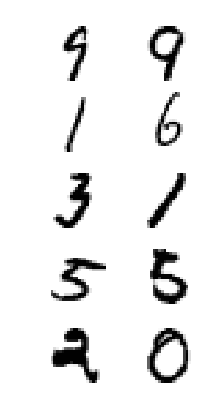

In [174]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [175]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Perfect!

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [176]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large `batch_size`, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [177]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.492426
0 Test accuracy: 0.7861
1 Train loss: 0.334813
2 Train loss: 0.290434
3 Train loss: 0.253434
4 Train loss: 0.217843
5 Train loss: 0.17127
5 Test accuracy: 0.9185
6 Train loss: 0.207128
7 Train loss: 0.172275
8 Train loss: 0.166783
9 Train loss: 0.161094
10 Train loss: 0.125131
10 Test accuracy: 0.9425
11 Train loss: 0.159824
12 Train loss: 0.124752
13 Train loss: 0.112234
14 Train loss: 0.114502
15 Train loss: 0.0950093
15 Test accuracy: 0.9532
16 Train loss: 0.119296
17 Train loss: 0.0754429
18 Train loss: 0.112295
19 Train loss: 0.133708
20 Train loss: 0.113547
20 Test accuracy: 0.9596
21 Train loss: 0.0674082
22 Train loss: 0.0936297
23 Train loss: 0.0986469
24 Train loss: 0.111875
25 Train loss: 0.0735623
25 Test accuracy: 0.9675
26 Train loss: 0.0790324
27 Train loss: 0.0487644
28 Train loss: 0.0869071
29 Train loss: 0.0694422
30 Train loss: 0.060089
30 Test accuracy: 0.9663
31 Train loss: 0.103902
32 Train loss: 0.0535952
33 Train loss: 0.0310679
34 Train l

All right, we reach 97.6% accuracy on this digit comparison task. That's not too bad, this model knows a thing or two about comparing handwritten digits!

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the `tf.stop_gradient()` function. Note that we need one `Saver` to restore the pretrained DNN A, and another `Saver` to save the final model: 

In [178]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [179]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9269
10 Test accuracy: 0.9675
20 Test accuracy: 0.9673
30 Test accuracy: 0.9673
40 Test accuracy: 0.9674
50 Test accuracy: 0.9673
60 Test accuracy: 0.9673
70 Test accuracy: 0.9673
80 Test accuracy: 0.9672
90 Test accuracy: 0.9673


Well, 96.7% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [180]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [181]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8893
10 Test accuracy: 0.9402
20 Test accuracy: 0.9479
30 Test accuracy: 0.9474
40 Test accuracy: 0.9479
50 Test accuracy: 0.9475
60 Test accuracy: 0.9475
70 Test accuracy: 0.9475
80 Test accuracy: 0.9476
90 Test accuracy: 0.9476
100 Test accuracy: 0.9473
110 Test accuracy: 0.9472
120 Test accuracy: 0.9474
130 Test accuracy: 0.9474
140 Test accuracy: 0.9475


Only 94.8% accuracy... So transfer learning helped us reduce the error rate from 5.2% to 3.3% (that's over 36% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.

Bottom line: transfer learning does not always work (as we saw in exercise 9), but when it does it can make a big difference. So try it out!